## Imports

In [1]:
from constants import ORIGINAL_FLUXES_FILE, \
                      ORIGINAL_SLM_FOLDER, \
                      ORIGINAL_AMPLITUDE_FILENAME, \
                      ORIGINAL_PHASE_FILENAME, \
                      TRAIN_FC_FLUXES_PATH, \
                      TRAIN_FC_AMP_PHASE_PATH, \
                      VALIDATION_FC_FLUXES_PATH, \
                      VALIDATION_FC_AMP_PHASE_PATH

from data_utils import load_numpy_data, normalize_data, flatten_data, fuse_amplitude_and_phase
                    

from plot_utils import plot_map, \
                       plot_model_history, \
                       plot_fully_connected_amp_phase_prediction

from modeling_utils import create_fully_connected_architecture_for_amplitude_and_phase_reconstruction, \
                           compile_model, \
                           train_model, \
                           train_model_with_generator, \
                           store_model

from configurations import SimpleFCModel as ModelConfig

2024-02-06 09:26:23.080320: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-06 09:26:23.394915: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 09:26:23.395137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 09:26:23.430226: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 09:26:23.529889: I tensorflow/core/platform/cpu_feature_guar

## Load data

In the first place, define the data paths

In [2]:
fluxes_array = load_numpy_data(ORIGINAL_FLUXES_FILE, n_points=10000)

train_amp_array = load_numpy_data(f"{ORIGINAL_SLM_FOLDER}00/{ORIGINAL_AMPLITUDE_FILENAME}")
val_amp_array = load_numpy_data(f"{ORIGINAL_SLM_FOLDER}01/{ORIGINAL_AMPLITUDE_FILENAME}")

train_phase_array = load_numpy_data(f"{ORIGINAL_SLM_FOLDER}00/{ORIGINAL_PHASE_FILENAME}")
val_phase_array = load_numpy_data(f"{ORIGINAL_SLM_FOLDER}01/{ORIGINAL_PHASE_FILENAME}")

In [3]:
fluxes_array, scaler = normalize_data(fluxes_array)

train_amp_array, scaler = normalize_data(train_amp_array)
val_amp_array, scaler = normalize_data(val_amp_array)

train_phase_array, scaler = normalize_data(train_phase_array)
val_phase_array, scaler = normalize_data(val_phase_array)

In [4]:
train_fluxes_array = flatten_data(fluxes_array)
validation_fluxes_array = fluxes_array[10000:]

In [5]:
train_amp_phase_array = fuse_amplitude_and_phase(train_amp_array, train_phase_array, axis=1)
validation_amp_phase_array = fuse_amplitude_and_phase(val_amp_array, val_phase_array, axis=1)

In [6]:
validation_fluxes_array = load_numpy_data(VALIDATION_FC_FLUXES_PATH)
validation_amp_phase_array = load_numpy_data(VALIDATION_FC_AMP_PHASE_PATH)

In [7]:
train_fluxes_array

array([[-0.36131857, -0.14848066,  0.01649273, ..., -0.75436927,
        -0.68680756, -0.68775995],
       [-0.29068664, -0.07443106,  0.08826388, ..., -0.8671525 ,
        -0.79959079, -0.78573326],
       [-0.25992758, -0.01974828,  0.16914882, ..., -0.89905079,
        -0.83490675, -0.81649233],
       ...,
       [-0.60283418, -0.30455442,  0.0335811 , ..., -0.92297451,
        -0.93857619, -0.92927556],
       [-0.86941273, -0.79669944, -0.71830712, ...,  0.81092529,
         0.80101973,  0.55855173],
       [-0.71219973, -0.50847562, -0.2443897 , ..., -0.85917793,
        -0.89528565, -0.93952858]])

In [8]:
validation_fluxes_array

array([[-0.8620921 , -0.78341   , -0.7261543 , ..., -0.11953966,
        -0.19919977, -0.3376131 ],
       [-0.5679936 , -0.24028566,  0.16628236, ..., -0.7674577 ,
        -0.80767936, -0.8548207 ],
       [-0.8823747 , -0.81834126, -0.7081253 , ...,  0.4235847 ,
         0.38674352,  0.19536993],
       ...,
       [-0.7629324 , -0.64481187, -0.53684956, ..., -0.9218312 ,
        -0.93726295, -0.92806363],
       [-0.7325084 , -0.5253696 , -0.21796122, ..., -0.6615372 ,
        -0.731056  , -0.7883387 ],
       [-0.8733602 , -0.8172144 , -0.74080294, ..., -0.12517372,
        -0.18680482, -0.2891601 ]], dtype=float32)

## Define configuration

In [9]:
model_configuration = ModelConfig()
print(model_configuration.get_description())


	=== OriginalDataSimpleFCModel ===
	*ARCHITECTURE HYPERPARAMETERS:
		-Fully Connected
		-Input shape: 1320
		-Output shape: (2, 96, 96)
		-Hidden layers: [2000, 2000, 2000, 2000]
		-Regularizer: None
		-Hidden Layers Activation: relu
		-Output Layer Activation: linear
		-Batch Normalization: False
		-Dropout: False, 0.1
	
	*COMPILATION HYPERPARAMETERS:
		-Optimizer: ADAM lr=0.0001, beta_1=0.9, beta_2=0.999
		-Loss Function: MSE
		-Metric: MSE
	
	* TRAINING HYPERPARAMETERS:
		-Epochs: 200
		-Batch size: 64
		-Callbacks: 
			-ReduceLROnPlateau: MSE 15 x0.1
			-Early Stop: MSE 50
	


2024-02-06 09:26:40.432293: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 09:26:40.510827: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 09:26:40.511395: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Instantiate model

In [10]:
model = create_fully_connected_architecture_for_amplitude_and_phase_reconstruction(
    *model_configuration.unpack_architecture_hyperparameters()
)


Model: "OriginalDataSimpleFCModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2000)              2640000   
                                                                 
 activation (Activation)     (None, 2000)              0         
                                                                 
 dense_1 (Dense)             (None, 2000)              4000000   
                                                                 
 activation_1 (Activation)   (None, 2000)              0         
                                                                 
 dense_2 (Dense)             (None, 2000)              4000000   
                                                                 
 activation_2 (Activation)   (None, 2000)              0         
                                                                 
 dense_3 (Dense)             (None, 2000)

## Compile model

In [11]:
compile_model(
    model,
    *model_configuration.unpack_compilation_hyperparameters()
)

## Train model

In [12]:
validation_amp_phase_array[0].shape

(2, 96, 96)

In [13]:
history = train_model(model, 
                      train_fluxes_array, 
                      train_amp_phase_array, 
                      validation_fluxes_array, 
                      validation_amp_phase_array,
                      *model_configuration.unpack_training_hyperparameters()
                    )


Epoch 1/200


2024-02-06 09:26:44.568034: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-06 09:26:45.596386: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f46663e2090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-06 09:26:45.596427: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-02-06 09:26:45.608371: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-06 09:26:45.643156: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1707172006.069287   43219 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 [==============================] - 10s 42ms/step - loss: 0.4624 - mean_squared_error: 0.4624 - val_loss: 0.8901 - val_mean_squared_error: 0.8901 - lr: 1.0000e-04
Epoch 2/200
157/157 [==============================] - 5s 32ms/step - loss: 0.3272 - mean_squared_error: 0.3272 - val_loss: 0.9126 - val_mean_squared_error: 0.9126 - lr: 1.0000e-04
Epoch 3/200
157/157 [==============================] - 5s 35ms/step - loss: 0.2995 - mean_squared_error: 0.2995 - val_loss: 0.9442 - val_mean_squared_error: 0.9442 - lr: 1.0000e-04
Epoch 4/200
157/157 [==============================] - 5s 35ms/step - loss: 0.2854 - mean_squared_error: 0.2854 - val_loss: 0.9685 - val_mean_squared_error: 0.9685 - lr: 1.0000e-04
Epoch 5/200
157/157 [==============================] - 6s 35ms/step - loss: 0.2720 - mean_squared_error: 0.2720 - val_loss: 0.9757 - val_mean_squared_error: 0.9757 - lr: 1.0000e-04
Epoch 6/200
157/157 [==============================] - 5s 32ms/step - loss: 0.2603 - mean_squared_error: 0

## Results

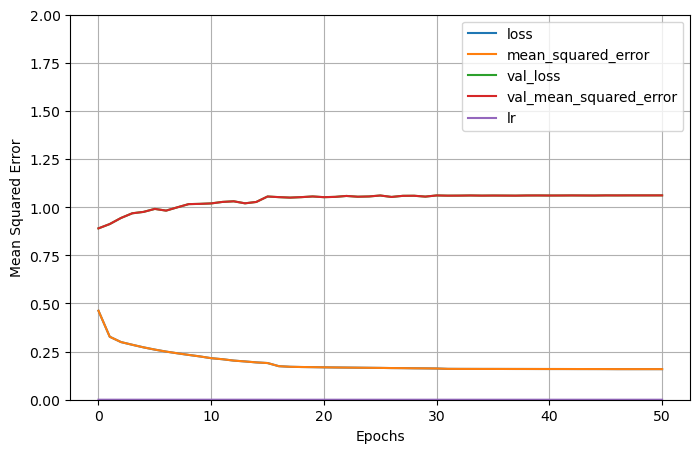

In [14]:
plot_model_history(history)

1/1 [==============================] - 0s 121ms/step


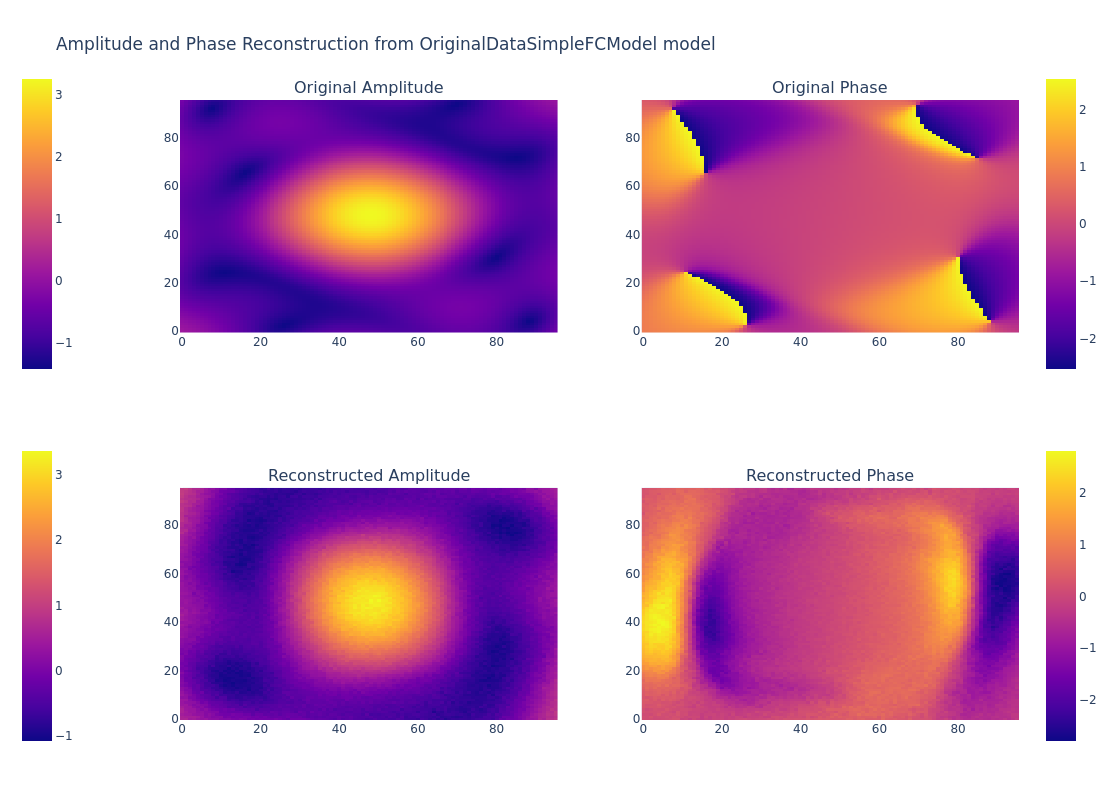

In [15]:
n = 106
plot_fully_connected_amp_phase_prediction(
    model,
    validation_fluxes_array[n],
    validation_amp_phase_array[n][0],
    validation_amp_phase_array[n][1]
    )

1/1 [==============================] - 0s 28ms/step


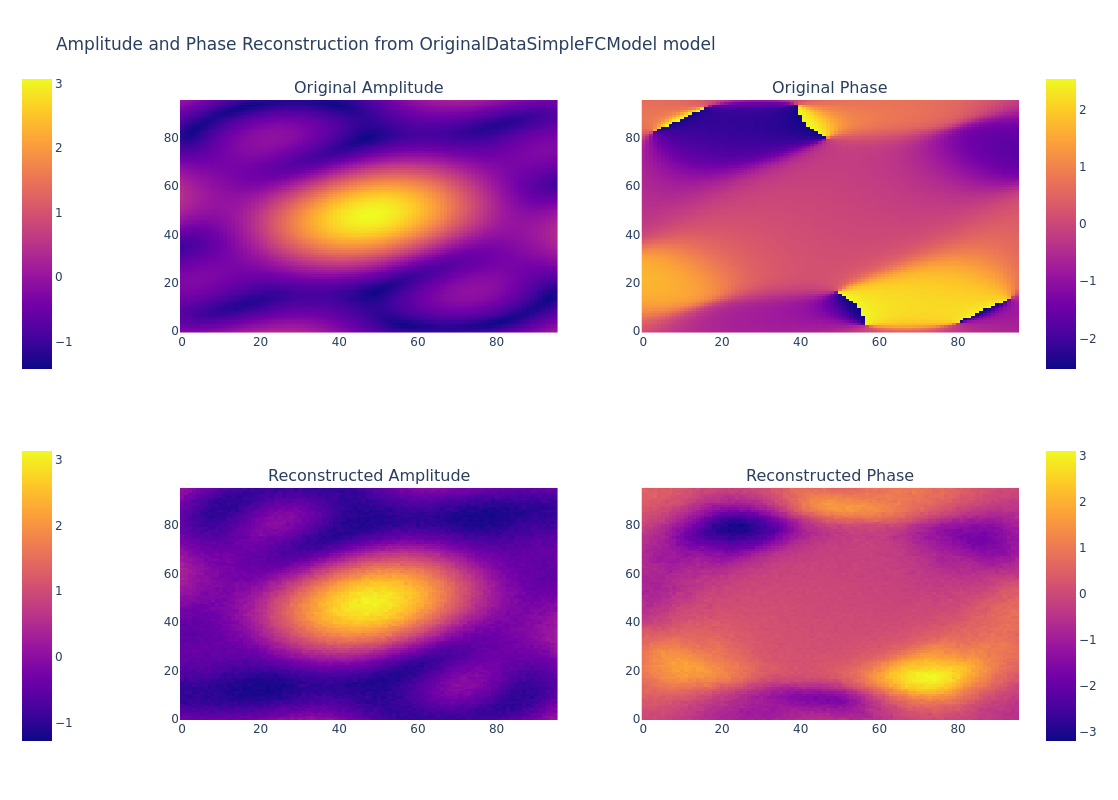

In [16]:
n = 106
plot_fully_connected_amp_phase_prediction(
    model,
    train_fluxes_array[n],
    train_amp_phase_array[n][0],
    train_amp_phase_array[n][1]
    )

In [17]:
store_model(model,
            model.name,
            model_configuration.get_description())